In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.api.types import CategoricalDtype
import re
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
months_dtype = CategoricalDtype(categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                                            'Sep','Oct','Nov','Dec'], ordered=True)

In [3]:
# Read CSV with all data from merged-pdfs.ipynb
df = pd.read_csv("finished-csvs/all-data-combined-long-format.csv", 
                 encoding="utf-8", dtype={'Month':months_dtype})
df.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
0,ASP,ASU EOP Hub,Actual Population,2009,Jan,0,df_2009_2019_melted
1,ASP,ASU Overflow,Actual Population,2009,Jan,0,df_2009_2019_melted
2,ASP,Academic Programs -\nAttendance Tracking,Average # Days in School (DIS),2009,Jan,98,df_2009_2019_melted
3,ASP,Academic Programs -\nAttendance Tracking,Average Daily Attendance,2009,Jan,663,df_2009_2019_melted
4,ASP,Academic Programs -\nAttendance Tracking,Avg. Length of Time in Assignment(LTA),2009,Jan,154,df_2009_2019_melted


In [4]:
# Filter to only high security prisons (https://www.cdcr.ca.gov/adult-operations/high-security/)
high_security = ["CCI", "COR", "LAC", "SAC", "HDSP", "KVSP", "PBSP", "SVSP"] # omit SATF and CAC
df_highsecurity = df.loc[df['Institution'].isin(high_security)]
df_highsecurity.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1497,CCI,ASU EOP Hub,Actual Population,2009,Jan,0,df_2009_2019_melted
1498,CCI,ASU Overflow,Actual Population,2009,Jan,26,df_2009_2019_melted
1499,CCI,Academic Programs -\nAttendance Tracking,Average # Days in School (DIS),2009,Jan,74,df_2009_2019_melted
1500,CCI,Academic Programs -\nAttendance Tracking,Average Daily Attendance,2009,Jan,280,df_2009_2019_melted
1501,CCI,Academic Programs -\nAttendance Tracking,Avg. Length of Time in Assignment(LTA),2009,Jan,144,df_2009_2019_melted


In [5]:
# See how many rows are duplicates
dup = df_highsecurity[df_highsecurity.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])]

In [6]:
dup['Year'].unique()

array([2019, 2020])

In [7]:
dup['Metric Title'].unique()

array(['Amphetamine Quantity', 'Barbiturates Quantity',
       'Cocaine Quantity', 'Codeine Quantity', 'Marijuana Quantity',
       'Methamphetamine Quantity', 'Morphine Quantity',
       'Synthetic Marijuana - Spice Quantity', 'Legal',
       'Appeals Received - 1st Level', 'Appeals Received - 2nd Level',
       'Appeals Received - 3rd Level', 'Screen Outs - 1st Level',
       'Administrative RVRs', 'Assault on a Peace Officer',
       'Assault on a Prisoner', 'Battery on a Peace Officer',
       'Battery on a Prisoner', 'Conduct', 'Fighting', 'Other',
       'Pending RVRs', 'Positive U.A.', 'Possession of Cell Phone(s)',
       'Serious RVRs', 'Half Time', 'Medical', 'Non-Custody',
       'Other Custody', 'Heroin Quantity', 'Appeals Denied - 2nd Level',
       'Assault with a Deadly Weapon', 'Attempted Murder',
       'Battery on a Non-Prisoner', 'Counseling RVRs',
       'Disturbance Riot or Strike', 'Sexual Disorderly Conduct',
       'Personal Property', 'Program', 'Staff Complain

In [8]:
# Some rows are repeats with errant zero values
df_highsecurity[(df_highsecurity['Year'] == 2020) & 
                (df_highsecurity['Metric Title'] == 'Documented Use of Force')].head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
2291996,CCI,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat
2291997,CCI,Number of Incidents,Documented Use of Force,2020,Jan,41,df_2020_2023_Incidents
2297057,COR,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat
2297058,COR,Number of Incidents,Documented Use of Force,2020,Jan,26,df_2020_2023_Incidents
2300738,HDSP,Number of Incidents,Documented Use of Force,2020,Jan,0,df_2020_2023_POP_no_cat


In [9]:
# Remove 2020 Documented Use of Force with zero values from df_2020_2023_POP_no_cat file
indices_of_repeated_zero_value = df_highsecurity[(df_highsecurity['Value'] == '0') & 
                                                 (df_highsecurity['Year'] == 2020) & 
                                                 (df_highsecurity['Metric Title'] == 'Documented Use of Force') &
                                                (df_highsecurity['file'] == 'df_2020_2023_POP_no_cat')].index
df_highsecurity.drop(index=indices_of_repeated_zero_value, inplace=True)

df_highsecurity[(df_highsecurity['Year'] == 2020) & 
                (df_highsecurity['Metric Title'] == 'Documented Use of Force')].head()

/var/folders/d_/d_l8pffd5g9339qj6mktkq580000gn/T/ipykernel_30694/3027264411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highsecurity.drop(index=indices_of_repeated_zero_value, inplace=True)


,Institution,Subcategory,Metric Title,Year,Month,Value,file
2291997,CCI,Number of Incidents,Documented Use of Force,2020,Jan,41,df_2020_2023_Incidents
2297058,COR,Number of Incidents,Documented Use of Force,2020,Jan,26,df_2020_2023_Incidents
2300739,HDSP,Number of Incidents,Documented Use of Force,2020,Jan,27,df_2020_2023_Incidents
2301981,KVSP,Number of Incidents,Documented Use of Force,2020,Jan,37,df_2020_2023_Incidents
2302610,LAC,Number of Incidents,Documented Use of Force,2020,Jan,43,df_2020_2023_Incidents


In [10]:
# Extract UOF Metrics
UOF = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Documented Use of Force|Total Number of Documented Force", regex=True)]
UOF.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1825,CCI,Number of Incidents,Total Number of Documented Force,2009,Jan,12,df_2009_2019_melted
5412,COR,Number of Incidents,Total Number of Documented Force,2009,Jan,21,df_2009_2019_melted
8435,HDSP,Number of Incidents,Total Number of Documented Force,2009,Jan,30,df_2009_2019_melted
9433,KVSP,Number of Incidents,Total Number of Documented Force,2009,Jan,26,df_2009_2019_melted
9961,LAC,Number of Incidents,Total Number of Documented Force,2009,Jan,36,df_2009_2019_melted


In [11]:
# Check if duplicates
np.sum(UOF.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])) # No UOF duplicates

0

In [13]:
POP = df_highsecurity[df_highsecurity['Metric Title'].str.contains("Inmate Count", regex=True)]
POP.head()

,Institution,Subcategory,Metric Title,Year,Month,Value,file
1932,CCI,Total Bed Capacity,Inmate Count,2009,Jan,5703,df_2009_2019_melted
5519,COR,Total Bed Capacity,Inmate Count,2009,Jan,5654,df_2009_2019_melted
8542,HDSP,Total Bed Capacity,Inmate Count,2009,Jan,4415,df_2009_2019_melted
9540,KVSP,Total Bed Capacity,Inmate Count,2009,Jan,4789,df_2009_2019_melted
10068,LAC,Total Bed Capacity,Inmate Count,2009,Jan,4906,df_2009_2019_melted


In [14]:
# Check if duplicates
np.sum(POP.duplicated(subset=['Institution', 'Subcategory', 'Metric Title',
                                                  'Year', 'Month'])) # No POP duplicates

0

In [16]:
# Merge the UOF extracted with POP extracted
df_merged = UOF.merge(POP, on=['Institution', 'Year', 'Month'], how='inner')
df_merged.head()

,Institution,Subcategory_x,Metric Title_x,Year,Month,Value_x,file_x,Subcategory_y,Metric Title_y,Value_y,file_y
0,CCI,Number of Incidents,Total Number of Documented Force,2009,Jan,12,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5703,df_2009_2019_melted
1,COR,Number of Incidents,Total Number of Documented Force,2009,Jan,21,df_2009_2019_melted,Total Bed Capacity,Inmate Count,5654,df_2009_2019_melted
2,HDSP,Number of Incidents,Total Number of Documented Force,2009,Jan,30,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4415,df_2009_2019_melted
3,KVSP,Number of Incidents,Total Number of Documented Force,2009,Jan,26,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4789,df_2009_2019_melted
4,LAC,Number of Incidents,Total Number of Documented Force,2009,Jan,36,df_2009_2019_melted,Total Bed Capacity,Inmate Count,4906,df_2009_2019_melted


In [18]:
# Drop unnecessary columns
df_merged_simplified = df_merged.drop(columns=['Subcategory_x', 'file_x', 'Metric Title_x', 'Subcategory_y', 'Metric Title_y', 'file_y'])
df_merged_simplified.head()

,Institution,Year,Month,Value_x,Value_y
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906


In [22]:
# Rename Value_x and Value_y to their respective sheets
df_renamed = df_merged_simplified.rename({'Value_x':'use_of_force', 
                                          'Value_y':'inmate_count'}, axis=1)
df_renamed

,Institution,Year,Month,use_of_force,inmate_count
0,CCI,2009,Jan,12,5703
1,COR,2009,Jan,21,5654
2,HDSP,2009,Jan,30,4415
3,KVSP,2009,Jan,26,4789
4,LAC,2009,Jan,36,4906
...,...,...,...,...,...
1387,KVSP,2023,Jun,35,2793
1388,LAC,2023,Jun,91,2660
1389,PBSP,2023,Jun,9,1627
1390,SAC,2023,Jun,47,1759


In [23]:
# Recast data types as integers for data analysis
df_UOF_rate = df_renamed.astype({'use_of_force':'Int64', 'inmate_count':'Int64'})
df_UOF_rate.dtypes

Institution       object
Year               int64
Month           category
use_of_force       Int64
inmate_count       Int64
dtype: object

In [24]:
# Add rate per 1000 inmates column 
df_UOF_rate['uof_per_1000'] = df_UOF_rate['use_of_force'] / df_UOF_rate['inmate_count'] * 1000
df_UOF_rate

,Institution,Year,Month,use_of_force,inmate_count,uof_per_1000
0,CCI,2009,Jan,12,5703,2.104156
1,COR,2009,Jan,21,5654,3.714185
2,HDSP,2009,Jan,30,4415,6.795017
3,KVSP,2009,Jan,26,4789,5.429108
4,LAC,2009,Jan,36,4906,7.337954
...,...,...,...,...,...,...
1387,KVSP,2023,Jun,35,2793,12.531328
1388,LAC,2023,Jun,91,2660,34.210526
1389,PBSP,2023,Jun,9,1627,5.531653
1390,SAC,2023,Jun,47,1759,26.719727


In [25]:
# Mean rate of each institution 
df_UOF_rate.groupby(['Institution'])['uof_per_1000'].mean()

Institution
CCI      6.536173
COR      8.198662
HDSP     7.102604
KVSP     9.555989
LAC       11.7095
PBSP     4.978565
SAC     18.942906
SVSP    13.145545
Name: uof_per_1000, dtype: Float64

In [26]:
# Count by institution
df_UOF_rate.groupby(['Institution']).count()

,Year,Month,use_of_force,inmate_count,uof_per_1000
Institution,,,,,
CCI,174,174,174,174,174
COR,174,174,174,174,174
HDSP,174,174,174,174,174
KVSP,174,174,174,174,174
LAC,174,174,174,174,174
PBSP,174,174,174,174,174
SAC,174,174,174,174,174
SVSP,174,174,174,174,174


In [27]:
df_UOF_rate['uof_per_1000'].mean()

10.021242967270082

In [28]:
df_UOF_rate.to_csv("analysis/use_of_force.csv", encoding="utf-8", index=False)

In [29]:
df_UOF_by_year = df_UOF_rate.groupby(['Year','Institution'])['uof_per_1000'].mean().reset_index()
df_UOF_by_year.head(10)

,Year,Institution,uof_per_1000
0,2009,CCI,3.78789
1,2009,COR,3.544667
2,2009,HDSP,7.011149
3,2009,KVSP,5.403689
4,2009,LAC,6.755302
5,2009,PBSP,4.561298
6,2009,SAC,11.998722
7,2009,SVSP,9.220388
8,2010,CCI,3.519126
9,2010,COR,3.618587


In [30]:
df_pivot = df_UOF_by_year.pivot(index='Year', columns='Institution', values='uof_per_1000')
df_pivot.head(10)

Institution,CCI,COR,HDSP,KVSP,LAC,PBSP,SAC,SVSP
Year,,,,,,,,
2009,3.78789,3.544667,7.011149,5.403689,6.755302,4.561298,11.998722,9.220388
2010,3.519126,3.618587,7.449524,7.89504,7.812434,4.995485,11.257568,10.319387
2011,5.076671,5.061804,6.573171,7.783116,8.796594,5.266022,12.546238,12.918531
2012,3.654187,5.648797,7.096301,8.740767,9.571889,6.247776,12.253709,11.556532
2013,3.350852,5.808224,5.769188,9.077043,9.790126,6.006076,14.22398,12.029029
2014,3.138168,6.03906,6.661476,6.951336,10.091247,2.818863,19.307105,11.262252
2015,2.971186,6.27283,6.241873,7.375688,10.841917,3.146455,20.724475,9.986828
2016,5.733652,8.416308,5.413288,9.431876,9.156539,4.851241,19.849676,11.425164
2017,7.970874,12.266563,5.928961,10.533691,12.358959,4.047213,18.824785,10.486783


<AxesSubplot:xlabel='Year'>

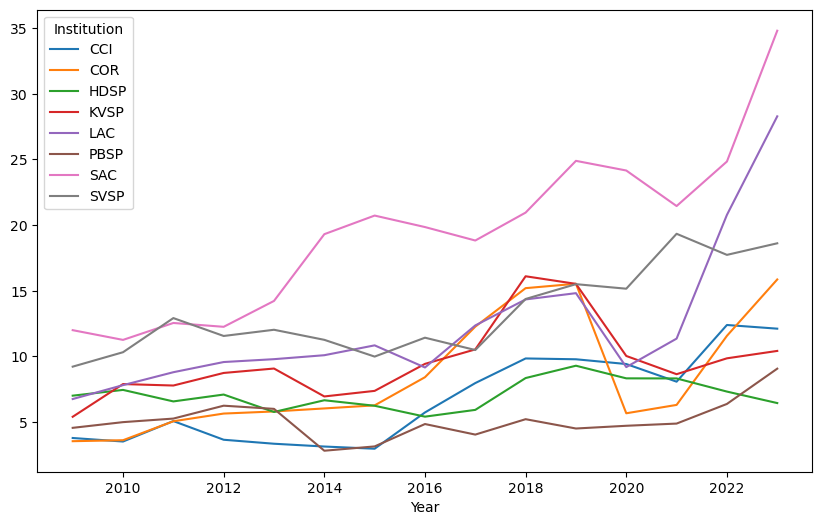

In [31]:
df_pivot.plot(figsize=(10,6))

In [32]:
df_UOF_by_month = df_UOF_rate.groupby(by=['Year','Month','Institution'])['uof_per_1000'].mean().reset_index()
df_UOF_by_month.head()

,Year,Month,Institution,uof_per_1000
0,2009,Jan,CCI,2.104156
1,2009,Jan,COR,3.714185
2,2009,Jan,HDSP,6.795017
3,2009,Jan,KVSP,5.429108
4,2009,Jan,LAC,7.337954


In [33]:
df_UOF_by_month_pivot = df_UOF_by_month.pivot(index=['Year','Month'], columns='Institution', values='uof_per_1000')
df_UOF_by_month_pivot.head(20)

Institution       CCI       COR       HDSP      KVSP        LAC      PBSP        SAC       SVSP
Year Month                                                                                     
2009 Jan     2.104156  3.714185   6.795017  5.429108   7.337954  3.535651  17.200675   7.045798
     Feb     4.314995  3.595829   7.459313  4.603474   7.106599   3.55345    8.77489   8.044243
     Mar     5.324206  3.814714   8.762076  5.418925   8.507989  5.993407   13.69863   8.174387
     Apr     4.011461  3.257919   6.055169  4.561476   7.734807  2.678571  10.020733   8.056872
     May     4.209721  2.586366   8.902738  7.475083   7.388092  7.491759  14.103887  10.218631
     Jun     3.735525  2.773156   7.266122  4.014367   6.294964  4.297115  13.296011  11.396011
     Jul     4.317323  3.685957   5.609154    6.1689   7.378472  5.564142  12.114919  10.630408
     Aug     3.112571  3.167505   6.723442  6.599957    6.61545  4.970488   12.22067  11.646804
     Sep     4.528828  3.989362   5.782918  5.260943    5.28653  4.361371   9.256085  10.041841
     Oct     3.522308  4.011461   6.261181  4.424779   3.197612  2.492212  12.741047   9.840426
     Nov     3.057065  3.375844   7.160439  5.280946   5.448997  3.591739   8.757704   5.428882
     Dec     3.216523  4.563709   7.356219  5.606312   8.766163  6.205674   11.79941   10.12035
2010 Jan      2.52738  2.734731    6.90577  6.672227   7.804032  6.237006   9.878169  10.829371
     Feb     3.870099  2.900127   3.732162  7.293186   7.346586  7.464915   8.606422    9.02096
     Mar     5.107252  3.082502   8.624502  6.644518  10.338759  3.549246  10.678608   8.224993
     Apr     2.519315  2.067281   7.385855  5.819996   8.705114  5.102041  14.026685  14.550265
     May     4.269126  4.390151   8.886914  6.416891    7.94702  8.433735  11.957636   7.637609
     Jun     3.206751  2.889617  10.738255   7.97984   8.216744  3.928679  14.710913   7.182761
     Jul     3.015075  3.259202   7.599464  9.388646    8.91886   5.78739  11.015491  11.729405
     Aug     2.180476  5.626698   8.602651   8.44556   5.550622   4.29053   9.989666   7.506702

<AxesSubplot:xlabel='Year,Month'>

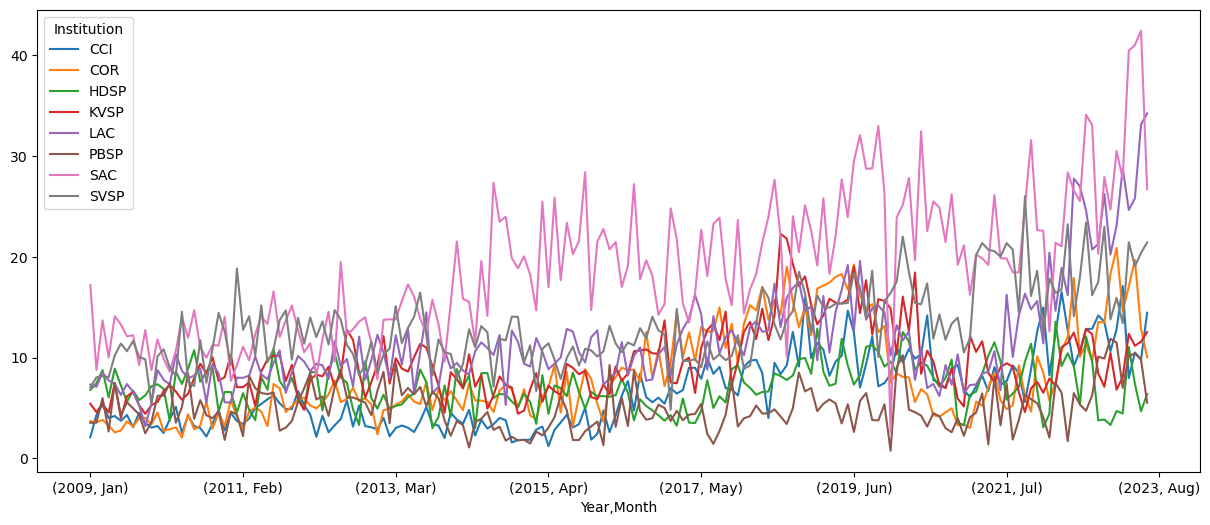

In [34]:
df_UOF_by_month_pivot.plot(figsize=(15,6))